In [1]:
%load_ext autoreload
%autoreload 2

In [151]:
from os.path import join, exists, isdir
import numpy as np
import cv2
from sklearn.cluster import KMeans

from stl10_input import read_single_image, read_all_images, read_labels, plot_image, keep_relevant_images
from constants import relevant_classes, idx_to_class
from utils import show_many_images, show_single_image

#### Define relevant paths

In [3]:
DATA_DIR = "./data/stl10_binary"

TRAIN_X_PATH = join(DATA_DIR, "train_X.bin")
TRAIN_y_PATH = join(DATA_DIR, "train_y.bin")

assert exists(TRAIN_X_PATH)
assert exists(TRAIN_y_PATH)

#### Load sample images

In [4]:
all_images = read_all_images(TRAIN_X_PATH)
all_labels = read_labels(TRAIN_y_PATH)

assert len(all_images) == len(all_labels)

In [5]:
all_images.shape, all_labels.shape

((5000, 96, 96, 3), (5000,))

In [6]:
np.unique(all_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [10]:
images, labels = keep_relevant_images(all_images, all_labels, relevant_classes)

In [11]:
images.shape, labels.shape

((2500, 96, 96, 3), (2500,))

#### Select small sample of images from each class

In [96]:
all_classes = np.unique(all_labels)

In [100]:
label_to_images = dict()

for label in all_classes:
    class_images, class_labels = keep_relevant_images(all_images, all_labels, [label])

    assert len(np.unique(class_labels)) == 1
    assert np.unique(class_labels)[0] == label

    label_to_images[label] = class_images

In [103]:
len(label_to_images)

10

In [104]:
def sample_images_per_class(label_to_images, num_samples=2, seed=0):
    np.random.seed(seed)
    
    sampled_images = []
    sampled_labels = []
    
    for label, images in label_to_images.items():
        indices = np.random.randint(0, len(images), num_samples)
        sampled_images.extend(images[indices])
        sampled_labels.extend([label] * num_samples)
    
    return sampled_images, sampled_labels

In [109]:
label_to_images_relevant = {k:v for k, v in label_to_images.items() if k in relevant_classes}
sampled_images, sampled_labels = sample_images_per_class(label_to_images_relevant)

In [110]:
len(sampled_images), len(sampled_labels)

(10, 10)

In [111]:
sampled_labels

[1, 1, 2, 2, 3, 3, 7, 7, 9, 9]

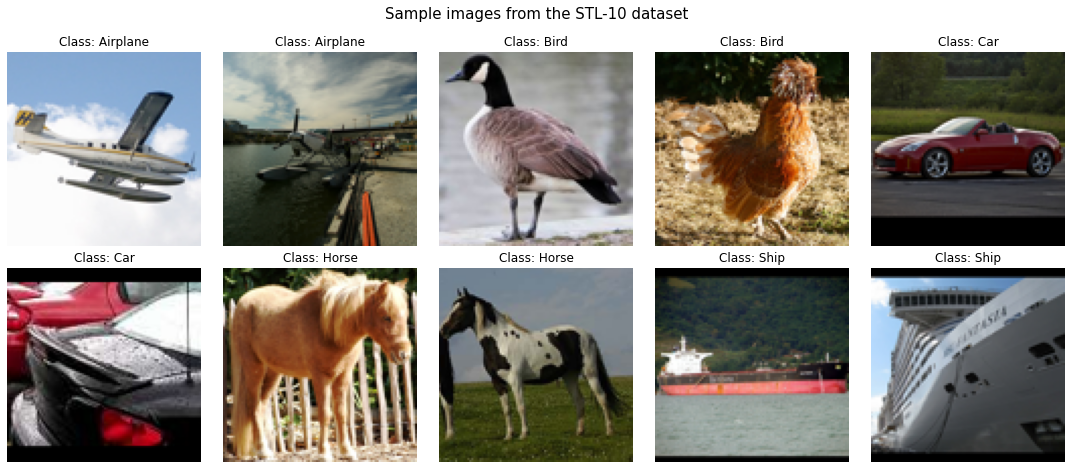

In [112]:
show_many_images(
    sampled_images,
    figsize=(15, 6),
    subtitles=[f"Class: {idx_to_class[l].capitalize()}" for l in sampled_labels],
    suptitle="Sample images from the STL-10 dataset",
    save=True,
    save_path="./results/data_samples.png"
)

#### Feature Extraction and Description

In [113]:
sift_args = dict()
SIFT = cv2.SIFT_create(**sift_args)

In [114]:
def mark_kps_on_image(image, kps, color=(0, 255, 0), kps_with_size=True):

    if kps_with_size:
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    else:
        flags=0

    image_with_kps = cv2.drawKeypoints(
        image, kps, None, color=color,
        flags=flags,
    )
    return image_with_kps

In [115]:
sampled_sift_outputs = []
sampled_sift_images = []

for img in sampled_images:
    kp, des = SIFT.detectAndCompute(img, None)
    sampled_sift_outputs.append({"kp": kp, "des": des})
    sampled_sift_images.append(mark_kps_on_image(img, kp))

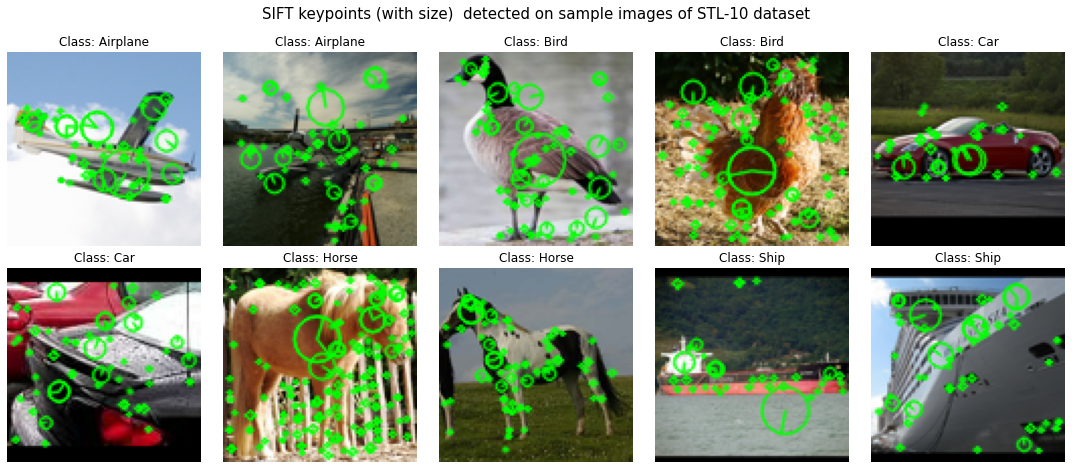

In [116]:
show_many_images(
    sampled_sift_images,
    figsize=(15, 6),
    subtitles=[f"Class: {idx_to_class[l].capitalize()}" for l in sampled_labels],
    suptitle="SIFT keypoints (with size)  detected on sample images of STL-10 dataset",
    save=True,
    save_path="./results/data_samples_with_sift.png"
)

#### Building Visual Vocabulary

In [310]:
NUM_CLUSTERS = 500

In [311]:
# sample 50% images from the training set s.t. all classes are covered
vv_images, vv_labels = sample_images_per_class(label_to_images, num_samples=250)

In [312]:
len(vv_images), len(vv_labels)

(2500, 2500)

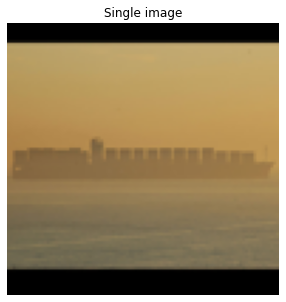

In [313]:
show_single_image(vv_images[2197])

In [314]:
kp, des = SIFT.detectAndCompute(vv_images[2197], None)

In [315]:
vv_sift_outputs = []
vv_sift_desc = []
vv_sift_images = []
store_sift_images = False

for img in vv_images:
    kp, des = SIFT.detectAndCompute(img, None)

    if des is not None:
        vv_sift_outputs.append({"kp": kp, "des": des})
        vv_sift_desc.append(des)

        if store_sift_images:
            vv_sift_images.append(mark_kps_on_image(img, kp))

In [316]:
len(vv_sift_outputs), len(vv_sift_desc)

(2499, 2499)

In [317]:
vv_descriptors = np.vstack(vv_sift_desc)

In [318]:
vv_descriptors.shape

(211957, 128)

In [319]:
import time

start = time.time()

kmeans = KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(vv_descriptors)

end = time.time()
print(f"::::: Finished K-Means on visual descriptors of size {vv_descriptors.shape} in {end - start} secs.")

::::: Finished K-Means on visual descriptors of size (211957, 128) in 465.71341609954834 secs.


In [320]:
cluster_centers = kmeans.cluster_centers_

In [321]:
import pickle

def load_pkl(path: str, encoding: str = "ascii"):
    """Loads a .pkl file.
    Args:
        path (str): path to the .pkl file
        encoding (str, optional): encoding to use for loading. Defaults to "ascii".
    Returns:
        Any: unpickled object
    """
    return pickle.load(open(path, "rb"), encoding=encoding)


def save_pkl(data, path: str) -> None:
    """Saves given object into .pkl file
    Args:
        data (Any): object to be saved
        path (str): path to the location to be saved at
    """
    with open(path, 'wb') as f:
        pickle.dump(data, f)


save_pkl(kmeans, f"kmeans_{NUM_CLUSTERS}.pkl")

In [322]:
vv_cluster_labels = kmeans.predict(vv_descriptors)

In [323]:
vv_cluster_labels.shape

(211957,)

##### Visualize the learnt clusters

In [324]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [325]:
def visualize_clusters(
        descriptors, cluster_labels, cluster_centers,
        viz_clusters=25, num_samples=10000, total_clusters=NUM_CLUSTERS, seed=0
    ):
    np.random.seed(seed)

    tsne = TSNE(n_components=2, random_state=seed)
    indices = np.random.randint(0, len(descriptors), num_samples)
    selected_clusters = np.random.randint(0, total_clusters, size=viz_clusters)
    mu = cluster_centers[selected_clusters]

    X = descriptors[indices]
    y = cluster_labels[indices]
    X_ = np.vstack([X, mu])
    
    y_ = np.concatenate([y, selected_clusters])
    Z = tsne.fit_transform(X_)

    df = pd.DataFrame(None, columns=["Z1", "Z2", "cluster_label", "style"])
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["cluster_label"] = y_
    df["style"] = ["circle" for i in range(len(X))] + ["cross" for i in range(len(X), len(Z))]

    subdf = df[df["cluster_label"].apply(lambda x: x in selected_clusters)]

    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    ax.grid()
    sns.scatterplot(
        data=subdf,
        x="Z1", y="Z2", hue="cluster_label", palette="Set2", legend=False, ax=ax, s=100, style="style",
    )
    ax.scatter(x=Z[len(X):, 0], y=Z[len(X):, 1], marker="x", s=100, c="black", label="Cluster centers")
    ax.set_title(f"Randomly selected {viz_clusters} clusters (out of {total_clusters}) visualized via TSNE embeddings.")
    
    plt.legend()
    plt.savefig(f"./results/random_{viz_clusters}_{total_clusters}_clusters.png", bbox_inches="tight")
    plt.show()

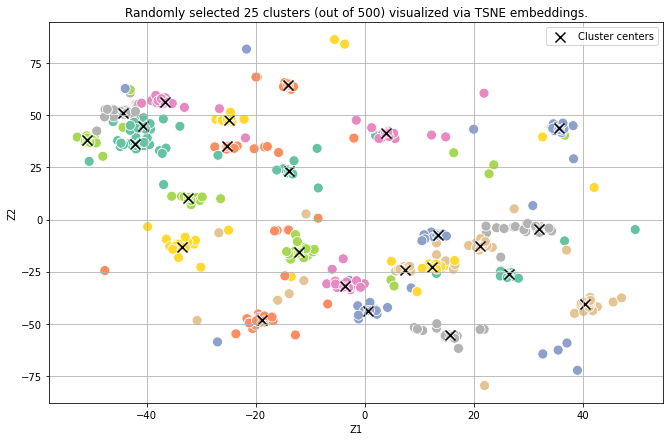

In [326]:
visualize_clusters(vv_descriptors, vv_cluster_labels, cluster_centers, viz_clusters=25)

#### Evaluate K-Means on remaining traning set

In [327]:
kmeans.score(vv_descriptors)

-15655451648.0

In [330]:
cluster_centers.shape

(500, 128)

In [331]:
visual_vocab = {k: cluster_centers[k] for k in range(len(cluster_centers))}

In [332]:
len(visual_vocab)

500

### Encoding Features Using Visual Vocabulary

In [354]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [355]:
nearest_ngbr_predictor = NearestNeighbors(n_neighbors=1).fit(cluster_centers)

In [360]:
def encoder(images: np.ndarray, show=False):
    """
    For a given batch of images,
        (1) computes SIFT descriptors
        (2) computes closest neighboring cluster centers
        (3) computes the frequency of visual words of size |vocabulary|
    """
    features = []
    for i, img in enumerate(tqdm(list(images))):
        kp, des = SIFT.detectAndCompute(img, None)

        if des is not None:
            distances, indices = nearest_ngbr_predictor.kneighbors(des)

            # the histogram of the data
            freq = np.histogram(indices, NUM_CLUSTERS)[0]
            assert np.sum(freq) == len(des)
            # normalize
            freq /= len(des)

            features.append(freq)

            if show:
                fig, ax = plt.subplots(1, 1, figsize=(10, 4))
                ax.grid()
                ax.bar(x=list(range(len(freq))), height=freq)
                ax.set_title(f"Frequency of visual words for image {i}")
                plt.show()

    return features

In [361]:
label_to_images_relevant.keys()

dict_keys([1, 2, 3, 7, 9])

In [376]:
label_to_image_features_relevant = dict()
label_to_image_features_agg_relevant = dict()

for label, images in label_to_images_relevant.items():
    features = encoder(images)
    label_to_image_features_relevant[label] = features
    label_to_image_features_agg_relevant[label] = np.mean(np.array(features), axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 324.64it/s]


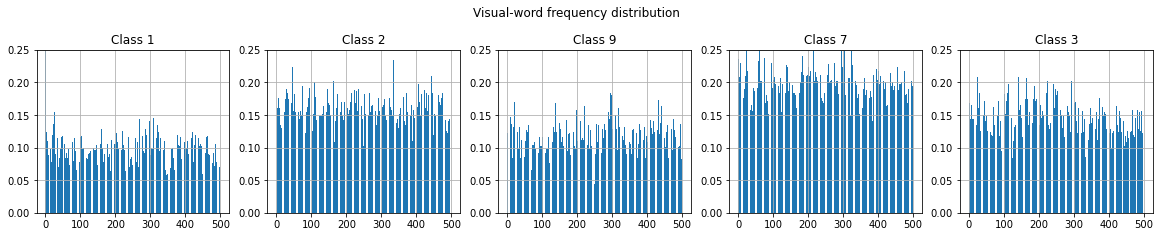

In [381]:
fig, axes = plt.subplots(1, len(relevant_classes), figsize=(20, 3))

for j, i in enumerate(relevant_classes):
    ax = axes[j]

    ax.grid()
    
    feat = label_to_image_features_agg_relevant[i]
    ax.bar(x=list(range(len(feat))), height=feat)
    ax.set_title(f"Class {i}")
    ax.set_ylim(0, 0.25)

plt.suptitle("Visual-word frequency distribution", y=1.08)
plt.show()